In [9]:
# Packages
%config InlineBackend.figure_format = 'retina'

#pip install highlight-text
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler

import datetime
import random 
from tqdm import tqdm

# Visualization
from highlight_text import htext
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch
from PIL import Image
import requests
from io import BytesIO

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


# Hyperparameter optimization
from functools import partial
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope

# Feature selection 
#pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Interpretation
import shap


# Let's import the data
dataset = pd.read_csv('data_matches.csv').drop('Unnamed: 0',axis=1)
dataset

,shots,shots_on_target,yellow_cards,red_cards,team_touches,pressures,tackles,interceptions,blocks,xg,...,pass_blocks,fouls,fouls_drawn,offside,penalties_won,penalties_conceded,ball_recoveries,aerials_won,aerials_lost,team_result
0,10,2,3,1,703,136,17,8,17,1.0,...,12,14,16,0,0,0,112,18,27,D
1,12,2,2,0,489,134,23,4,8,0.9,...,7,11,10,3,0,0,100,24,26,W
2,12,0,3,0,671,172,13,2,7,1.0,...,5,18,10,1,0,0,97,30,17,L
3,15,6,1,0,646,132,24,9,11,1.2,...,9,12,12,1,0,0,116,26,26,W
4,14,5,4,0,650,174,21,9,24,1.3,...,20,14,4,0,0,0,114,23,22,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,7,2,1,0,668,72,24,10,13,0.4,...,10,8,17,3,0,0,74,14,11,L
60,3,1,2,0,436,175,22,14,18,1.2,...,13,9,10,0,0,0,74,16,13,L
61,8,5,1,0,424,167,17,10,20,1.6,...,17,14,10,2,1,0,82,16,16,W
62,7,1,0,0,580,177,24,19,19,1.5,...,15,13,10,4,0,0,87,34,17,W


Variables such as 'assists' and 'goals' are not considered since they can negatively impact this analysis's goal. I am interested in finding those crucial events at the base of the goal's action, trying to understand Everton's characteristics' main dynamics. 

#### Target variable

In [10]:
target_variable = [] # team_result

for i in range(0,dataset['team_result'].shape[0]):
    if(dataset['team_result'].iloc[i] == 'L' ):
        target_variable.append(0)
    else:
        target_variable.append(1)

y = pd.DataFrame(target_variable)
y.columns = ["Result"]

y.Result.value_counts()

1    41
0    23
Name: Result, dtype: int64

#### Train and test set

In [11]:
y = np.array(y).ravel()
X = np.array(dataset.drop(['team_result'],axis=1)).astype(np.float64)  

num_samples_train = int(X.shape[0] * 0.75)

X_training_data = X[:num_samples_train,:]
X_test_data = X[num_samples_train:,:]

train_labels = y[:num_samples_train]
test_labels = y[num_samples_train:]


print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', X_training_data.shape)
print('Test features shape:', X_test_data.shape)

Training labels shape: (48,)
Test labels shape: (16,)
Training features shape: (48, 87)
Test features shape: (16, 87)


#### Cross-validation splits, we are working with time-dependent data.

In [12]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit()
tscv = TimeSeriesSplit(n_splits=44,test_size=1)


# First 5 splits.
i = 0
for train_index, val_index in tscv.split(X_training_data):
    i = i + 1
    print('TRAIN:', train_index, 'VAL:', val_index)
    if(i==5):
        break 

TRAIN: [0 1 2 3] VAL: [4]
TRAIN: [0 1 2 3 4] VAL: [5]
TRAIN: [0 1 2 3 4 5] VAL: [6]
TRAIN: [0 1 2 3 4 5 6] VAL: [7]
TRAIN: [0 1 2 3 4 5 6 7] VAL: [8]


## Baseline model

In [13]:
# Logistic Regression

scaler = StandardScaler()
train_features = scaler.fit_transform(X_training_data)
test_features = scaler.transform(X_test_data)

def optimize(params):
    
    
    model = LogisticRegression(**params,
                               solver='liblinear', 
                               random_state=42)
    
    accuracy = []
    for train_index, val_index in tscv.split(train_features):
        X_train, X_val = train_features[train_index], train_features[val_index]
        y_train, y_val = train_labels[train_index], train_labels[val_index]
        
        model.fit(X_train,y_train)
        y_pred = model.predict(X_val)
        accuracy.append(accuracy_score(y_val, y_pred))
        
    score = - np.array(accuracy).mean()    
    return score

param_space = {
    'C': hp.loguniform('C', low=-4*np.log(10), high=4*np.log(10)),
    'penalty': hp.choice('penalty',['l1','l2'])
}

hopt = fmin(fn = optimize,
            space = param_space, 
            algo = tpe.suggest, 
            max_evals = 250,
            rstate= np.random.RandomState(42))


# Fitting the model
logistic = LogisticRegression(C = hopt['C'], 
                              penalty = 'l2' if hopt['penalty'] == 1 else 'l1', 
                              solver='liblinear', 
                              random_state=42)
logistic.fit(train_features, train_labels.ravel()) 
    
y_pred = logistic.predict(test_features)

print(f'The accuracy is: {accuracy_score(test_labels,y_pred) }')
print(f'The precision is: {precision_score(test_labels,y_pred)}')
print(f'The recall is: {recall_score(test_labels,y_pred)}')
print(f'The f1 is: {f1_score(test_labels,y_pred)}')

100%|██████████| 250/250 [00:13<00:00, 18.99trial/s, best loss: -0.6590909090909091]
The accuracy is: 0.625
The precision is: 0.75
The recall is: 0.75
The f1 is: 0.75


Let's try an SVC Classifier that should work better in the contexts in which p is >> than n.

In [14]:
# Support Vector Classifier
scaler = StandardScaler()
train_features = scaler.fit_transform(X_training_data)
test_features = scaler.transform(X_test_data)

def optimize(params):
    
    
    model = SVC(**params, 
                random_state=42, 
                probability = True)
    
    accuracy = []
    for train_index, val_index in tscv.split(train_features):
        X_train, X_val = train_features[train_index], train_features[val_index]
        y_train, y_val = train_labels[train_index], train_labels[val_index]
        
        model.fit(X_train,y_train)
        y_pred = model.predict(X_val)
        accuracy.append(accuracy_score(y_val, y_pred))
        
    score = - np.array(accuracy).mean()    
    return score

param_space = {
    'C': hp.loguniform('C', low=-4*np.log(10), high=4*np.log(10)),
    'class_weight': hp.choice('class_weight',['balanced',None]),
    'gamma': hp.loguniform('gamma', low=-4*np.log(100), high=4*np.log(1))
    
}

hopt = fmin(fn=optimize,
            space=param_space, 
            algo = tpe.suggest, 
            max_evals=250,
            rstate= np.random.RandomState(42))


# Fitting the model
svc = SVC(C = hopt['C'], 
          class_weight = None if hopt['class_weight'] == 1 else 'balanced',
          gamma = hopt['gamma'],
          random_state = 42,
          probability = True
)
svc.fit(train_features, train_labels.ravel()) 
    
y_pred = svc.predict(test_features)

print(f'The accuracy is: {round(accuracy_score(test_labels,y_pred),2) }')
print(f'The precision is: {round(precision_score(test_labels,y_pred),2)}')
print(f'The recall is: {round(recall_score(test_labels,y_pred),2)}')
print(f'The f1 is: {round(f1_score(test_labels,y_pred),2)}')

100%|██████████| 250/250 [00:19<00:00, 12.60trial/s, best loss: -0.6363636363636364]
The accuracy is: 0.69
The precision is: 0.82
The recall is: 0.75
The f1 is: 0.78


## Feature Engineering

The term "Completed" for some variables does not have a great value if it is not compared to "attempted" through a percentage. For instance, 10 passes completed on 11 attempted is not the same as 10 passes completed on 20 attempted. The number of "completed" is the same but the percentage changes. This information should increase the quality of the prediction.

In [15]:
#'progressive_distance_passed'
dataset = dataset.assign(progressive_distance_passed=dataset['progressive_distance_passed'] / dataset['total_distance_passed'])
dataset = dataset.rename(columns = {'progressive_distance_passed':'progressive_distance_passed_percentage'})

#'progressive_distance_carried'
dataset = dataset.assign(progressive_distance_carried=dataset['progressive_distance_carried'] / dataset['carries_total_distance'])
dataset = dataset.rename(columns = {'progressive_distance_carried':'progressive_distance_carried_percentage'})

#Passes
dataset = dataset.assign(passes_completed=dataset['passes_completed'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'passes_completed':'passes_percentage'})

#Dribbles
dataset = dataset.assign(dribbles_completed=dataset['dribbles_completed'] / dataset['dribbles_attempted'])
dataset = dataset.rename(columns = {'dribbles_completed':'dribbles_percentage'})

#short_passes
a = dataset['short_passes_completed']
dataset = dataset.assign(short_passes_completed=dataset['short_passes_completed'] / dataset['short_passes_attempted'])
dataset = dataset.rename(columns = {'short_passes_completed':'short_passes_precision'})

dataset = dataset.assign(short_passes_attempted= a / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'short_passes_attempted':'short_passes_percentage'})

#medium_passes
a = dataset['medium_passes_completed'] 
dataset = dataset.assign(medium_passes_completed=dataset['medium_passes_completed'] / dataset['medium_passes_attempted'])
dataset = dataset.rename(columns = {'medium_passes_completed':'medium_passes_precision'})

dataset = dataset.assign(medium_passes_attempted= a / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'medium_passes_attempted':'medium_passes_percentage'})

#long_passes
dataset['long_passes_completed'] = dataset['long_passes_completed'].astype(int)
a = dataset['long_passes_completed']
dataset = dataset.assign(long_passes_completed=dataset['long_passes_completed'] / dataset['long_passes_attempted'])
dataset = dataset.rename(columns = {'long_passes_completed':'long_passes_precision'})

dataset = dataset.assign(long_passes_attempted= a / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'long_passes_attempted':'long_passes_percentage'})

#tackles
dataset = dataset.assign(tackles_won=dataset['tackles_won'] / dataset['tackles_attempted'])
dataset = dataset.rename(columns = {'tackles_won':'tackles_percentage'})

#dribbler_tackles
dataset = dataset.assign(dribbler_tackles_completed=dataset['dribbler_tackles_completed'] / dataset['dribbler_tackles_attempted'])
dataset = dataset.rename(columns = {'dribbler_tackles_completed':'dribbler_tackles_percentage'})

#shots
dataset = dataset.assign(shots_on_target=dataset['shots_on_target'] / dataset['shots'])
dataset = dataset.rename(columns = {'shots_on_target':'shots_on_target_percentage'})

#defensive_pen_area_touches
dataset = dataset.assign(defensive_pen_area_touches=dataset['defensive_pen_area_touches'] / dataset['team_touches'])
dataset = dataset.rename(columns = {'defensive_pen_area_touches':'defensive_pen_area_touches_percentage'})

#M3_touches
dataset = dataset.assign(M3_touches=dataset['M3_touches'] / dataset['team_touches'])
dataset = dataset.rename(columns = {'M3_touches':'M3_touches_percentage'})

#D3_touches
dataset = dataset.assign(D3_touches=dataset['D3_touches'] / dataset['team_touches'])
dataset = dataset.rename(columns = {'D3_touches':'D3_touches_percentage'})

#A3_touches
dataset = dataset.assign(A3_touches=dataset['A3_touches'] / dataset['team_touches'])
dataset = dataset.rename(columns = {'A3_touches':'A3_touches_percentage'})

#attacking_pen_area_touches
dataset = dataset.assign(attacking_pen_area_touches =dataset['attacking_pen_area_touches'] / dataset['team_touches'])
dataset = dataset.rename(columns = {'attacking_pen_area_touches':'attacking_pen_area_touches_percentage'})

#'live_ball_touches'
dataset = dataset.assign(live_ball_touches =dataset['live_ball_touches'] / dataset['team_touches'])
dataset = dataset.rename(columns = {'live_ball_touches':'live_ball_touches_percentage'})

# 'pass_target' relate to 'passes_received'
dataset = dataset.assign(passes_received =dataset['passes_received'] / dataset['pass_target'])
dataset = dataset.rename(columns = {'passes_received':'passes_received_percentage'})

#'miscontrols'
dataset = dataset.assign(miscontrols =dataset['miscontrols'] / dataset['carries'])
dataset = dataset.rename(columns = {'miscontrols':'miscontrols_percentage'})
               
#'possessions_lost'
dataset = dataset.assign(possessions_lost =dataset['possessions_lost'] / dataset['carries'])
dataset = dataset.rename(columns = {'possessions_lost':'possessions_lost_percentage'})

#'key_passes'
dataset = dataset.assign(key_passes =dataset['key_passes'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'key_passes':'key_passes_percentage'})

#'final_third_entry_passes' 
dataset = dataset.assign(final_third_entry_passes =dataset['final_third_entry_passes'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'final_third_entry_passes' :'final_third_entry_passes_percentage'})

#'penalty_area_entry_passes'
dataset = dataset.assign(penalty_area_entry_passes =dataset['penalty_area_entry_passes'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'penalty_area_entry_passes':'penalty_area_entry_passes_percentage'})

#'penalty_area_entry_crosses' 
dataset = dataset.assign(penalty_area_entry_crosses =dataset['penalty_area_entry_crosses'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'penalty_area_entry_crosses':'penalty_area_entry_crosses_percentage'})

#'progressive_passes'
dataset = dataset.assign(progressive_passes =dataset['progressive_passes'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'progressive_passes': 'progressive_passes_percentage'})

#'D3_tackles'
dataset = dataset.assign(D3_tackles =dataset['D3_tackles'] / dataset['tackles_attempted'])
dataset = dataset.rename(columns = {'D3_tackles': 'D3_tackles_percentage'})

#'M3_tackles' 
dataset = dataset.assign(M3_tackles =dataset['M3_tackles' ] / dataset['tackles_attempted'])
dataset = dataset.rename(columns = {'M3_tackles': 'M3_tackles_percentage'})

#'A3_tackles'
dataset = dataset.assign(A3_tackles =dataset['A3_tackles'] / dataset['tackles_attempted'])
dataset = dataset.rename(columns = {'A3_tackles': 'A3_tackles_percentage'})

#'pressure_regains'
dataset = dataset.assign(pressure_regains =dataset['pressure_regains'] / dataset['pressures'])
dataset = dataset.rename(columns = {'pressure_regains': 'pressure_regains_percentage'})

#'D3_pressures'
dataset = dataset.assign(D3_pressures =dataset['D3_pressures'] / dataset['pressures'])
dataset = dataset.rename(columns = {'D3_pressures': 'D3_pressures_percentage'})

#'M3_pressures'
dataset = dataset.assign(M3_pressures =dataset['M3_pressures'] / dataset['pressures'])
dataset = dataset.rename(columns = {'M3_pressures': 'M3_pressures_percentage'})

#'A3_pressures'
dataset = dataset.assign(A3_pressures =dataset['A3_pressures'] / dataset['pressures'])
dataset = dataset.rename(columns = {'A3_pressures': 'A3_pressures_percentage'})

#'live_ball_passes'
dataset = dataset.assign(live_ball_passes =dataset['live_ball_passes'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'live_ball_passes': 'live_ball_passes_percentage'})

#'dead_ball_passes'
dataset = dataset.assign(dead_ball_passes =dataset['dead_ball_passes'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'dead_ball_passes': 'dead_ball_passes_percentage'})

#'through_balls'
dataset = dataset.assign(through_balls =dataset['through_balls'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'through_balls': 'through_balls_percentage'})

#'pressured_passes'
dataset = dataset.assign(pressured_passes =dataset['pressured_passes'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'pressured_passes': 'pressured_passes_percentage'})

#'switch_passes'
dataset = dataset.assign(switch_passes =dataset['switch_passes'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'switch_passes': 'switch_passes_percentage'})

#'ground_passes'
dataset = dataset.assign(ground_passes =dataset['ground_passes'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'ground_passes': 'ground_passes_percentage'})

#'low_passes'
dataset = dataset.assign(low_passes =dataset['low_passes'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'low_passes': 'low_passes_percentage'})

#'hight_passes'
dataset = dataset.assign(hight_passes =dataset['hight_passes'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'hight_passes': 'hight_passes_percentage'})

#'left_foot_passes' 
dataset = dataset.assign(left_foot_passes =dataset['left_foot_passes'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'left_foot_passes': 'left_foot_passes_percentage'})

#'right_foot_passes' 
dataset = dataset.assign(right_foot_passes =dataset['right_foot_passes'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'right_foot_passes': 'right_foot_passes_percentage'})

#'head_passes'
dataset = dataset.assign(head_passes =dataset['head_passes'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'head_passes': 'head_passes_percentage'})

#'other_pass_type'
dataset = dataset.assign(other_pass_type =dataset['other_pass_type'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'other_pass_type': 'other_pass_type_percentage'})

#'passes_to_offside'
dataset = dataset.assign(passes_to_offside =dataset['passes_to_offside'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'passes_to_offside': 'passes_to_offside_percentage'})

#'passes_out_of_play'
dataset = dataset.assign(passes_out_of_play =dataset['passes_out_of_play'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'passes_out_of_play': 'passes_out_of_play_percentage'})

#'passes_intercepted'
dataset = dataset.assign(passes_intercepted =dataset['passes_intercepted'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'passes_intercepted': 'passes_intercepted_percentage'})

#'passes_blocked'
dataset = dataset.assign(passes_blocked =dataset['passes_blocked'] / dataset['passes_attempted'])
dataset = dataset.rename(columns = {'passes_blocked': 'passes_blocked_percentage'})

#'aerials_won'
a = dataset['aerials_won'] + dataset['aerials_lost']
dataset = dataset.assign(aerials_won =dataset['aerials_won'] / a )
dataset = dataset.rename(columns = {'aerials_won': 'aerials_won_percentage'})

#'aerials_lost'
dataset = dataset.assign(aerials_lost = a)
dataset = dataset.rename(columns = {'aerials_lost': 'total_aerials'})

Let's observe possible improvements in the prediction's quality.

In [16]:
y = np.array(y).ravel()
X = np.array(dataset.drop(['team_result'],axis=1)).astype(np.float64)  

num_samples_train = int(X.shape[0] * 0.75)

X_training_data = X[:num_samples_train,:]
X_test_data = X[num_samples_train:,:]

train_labels = y[:num_samples_train]
test_labels = y[num_samples_train:]


print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', X_training_data.shape)
print('Test features shape:', X_test_data.shape)

Training labels shape: (48,)
Test labels shape: (16,)
Training features shape: (48, 87)
Test features shape: (16, 87)


In [17]:
# Support Vector Classifier
scaler = StandardScaler()
train_features = scaler.fit_transform(X_training_data)
test_features = scaler.transform(X_test_data)

def optimize(params):
    
    
    model = SVC(**params, 
                random_state=42, 
                probability=True)
    
    accuracy = []
    for train_index, val_index in tscv.split(train_features):
        X_train, X_val = train_features[train_index], train_features[val_index]
        y_train, y_val = train_labels[train_index], train_labels[val_index]
        
        model.fit(X_train,y_train)
        y_pred = model.predict(X_val)
        accuracy.append(accuracy_score(y_val, y_pred))
        
    score = - np.array(accuracy).mean()    
    return score

param_space = {
    'C': hp.loguniform('C', low=-4*np.log(10), high=4*np.log(10)),
    'class_weight': hp.choice('class_weight',['balanced',None]),
    'gamma': hp.loguniform('gamma', low=-4*np.log(100), high=4*np.log(1))
    
}

hopt = fmin(fn=optimize,
            space=param_space, 
            algo = tpe.suggest, 
            max_evals=250,
            rstate= np.random.RandomState(42))


# Fitting the model
svc = SVC(C = hopt['C'],
          probability = True,
          class_weight = None if hopt['class_weight'] == 1 else 'balanced',
          gamma = hopt['gamma'],
          random_state = 42
)
svc.fit(train_features, train_labels.ravel()) 
    
y_pred = svc.predict(test_features)

print(f'The accuracy is: {round(accuracy_score(test_labels,y_pred),2) }')
print(f'The precision is: {round(precision_score(test_labels,y_pred),2)}')
print(f'The recall is: {round(recall_score(test_labels,y_pred),2)}')
print(f'The f1 is: {round(f1_score(test_labels,y_pred),2)}')

100%|██████████| 250/250 [00:25<00:00,  9.77trial/s, best loss: -0.6136363636363636]
The accuracy is: 0.62
The precision is: 0.88
The recall is: 0.58
The f1 is: 0.7


## Feature selection

In [18]:
# Forward selection
sfs1 = SFS(svc,
           k_features=train_features.shape[1], 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=list(tscv.split(train_features)))

sfs1 = sfs1.fit(train_features, train_labels.ravel(), 
                custom_feature_names=dataset.drop(['team_result'],axis=1).columns)

In [19]:
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(5,)","[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",0.636364,"(pressures,)",0.147845,0.481046,0.073359
2,"(2, 5)","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",0.659091,"(yellow_cards, pressures)",0.145684,0.474015,0.072287
3,"(2, 5, 71)","[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",0.727273,"(yellow_cards, pressures, head_passes_percentage)",0.136878,0.445362,0.067917
4,"(2, 5, 9, 71)","[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",0.795455,"(yellow_cards, pressures, xg, head_passes_perc...",0.123972,0.403369,0.061513
5,"(2, 5, 9, 21, 71)","[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.818182,"(yellow_cards, pressures, xg, D3_touches_perce...",0.11854,0.385695,0.058818
...,...,...,...,...,...,...,...
83,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...",0.636364,"(shots, shots_on_target_percentage, yellow_car...",0.147845,0.481046,0.073359
84,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...",0.636364,"(shots, shots_on_target_percentage, yellow_car...",0.147845,0.481046,0.073359
85,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...",0.613636,"(shots, shots_on_target_percentage, yellow_car...",0.149649,0.486916,0.074254
86,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...",0.590909,"(shots, shots_on_target_percentage, yellow_car...",0.151109,0.491666,0.074978


Among all these 87 models, let's select the model with the highest test accuracy.

In [21]:
total_accuracy = []
total_f1 = []

for i in range(1,len(sfs1.subsets_)):
    
    y = np.array(y).ravel()
    X = np.array(dataset[list(sfs1.subsets_[i]['feature_names'])]).astype(np.float64)  

    num_samples_train = int(X.shape[0] * 0.75)

    X_training_data = X[:num_samples_train,:]
    X_test_data = X[num_samples_train:,:]

    train_labels = y[:num_samples_train]
    test_labels = y[num_samples_train:]


    # SVC

    scaler = StandardScaler()
    train_features = scaler.fit_transform(X_training_data)
    test_features = scaler.transform(X_test_data)

    
    def optimize(params):
        model = SVC(**params, 
                    random_state=42, 
                    probability = True)
    
        accuracy = []
        for train_index, val_index in tscv.split(train_features):
            X_train, X_val = train_features[train_index], train_features[val_index]
            y_train, y_val = train_labels[train_index], train_labels[val_index]
        
            model.fit(X_train,y_train)
            y_pred = model.predict(X_val)
            accuracy.append(accuracy_score(y_val, y_pred))
        
        score = - np.array(accuracy).mean()    
        return score

    param_space = {
        'C': hp.loguniform('C', low=-4*np.log(10), high=4*np.log(10)),
        'class_weight': hp.choice('class_weight',['balanced',None]),
        'gamma': hp.loguniform('gamma', low=-4*np.log(100), high=4*np.log(1))
    }

    hopt = fmin(fn=optimize,
                space=param_space, 
                algo = tpe.suggest, 
                max_evals=250,
                rstate= np.random.RandomState(42))


    # Fitting the model
    svc = SVC(C = hopt['C'], 
              class_weight = None if hopt['class_weight'] == 1 else 'balanced',
              gamma = hopt['gamma'], 
              random_state=42,
              probability = True
    )
    svc.fit(train_features, train_labels.ravel()) 
    
    y_pred = svc.predict(test_features)
    total_accuracy.append(accuracy_score(test_labels,y_pred))
    total_f1.append(f1_score(test_labels,y_pred))

100%|██████████| 250/250 [00:18<00:00, 13.65trial/s, best loss: -0.5909090909090909]


In [22]:
m = max(total_accuracy)
[i + 1 for i, j in enumerate(total_accuracy) if j == m][0]

4

Let's observe possible improvements from the baseline model.

In [23]:
y = np.array(y).ravel()
X = np.array(dataset[list(sfs1.subsets_[4]['feature_names'])]).astype(np.float64)  

num_samples_train = int(X.shape[0] * 0.75)

X_training_data = X[:num_samples_train,:]
X_test_data = X[num_samples_train:,:]

train_labels = y[:num_samples_train]
test_labels = y[num_samples_train:]


print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', X_training_data.shape)
print('Test features shape:', X_test_data.shape)

Training labels shape: (48,)
Test labels shape: (16,)
Training features shape: (48, 4)
Test features shape: (16, 4)


In [24]:
# Support Vector Classifier
scaler = StandardScaler()
train_features = scaler.fit_transform(X_training_data)
test_features = scaler.transform(X_test_data)

def optimize(params):
    
    
    model = SVC(**params, 
                random_state=42, 
                probability= True)
    
    accuracy = []
    for train_index, val_index in tscv.split(train_features):
        X_train, X_val = train_features[train_index], train_features[val_index]
        y_train, y_val = train_labels[train_index], train_labels[val_index]
        
        model.fit(X_train,y_train)
        y_pred = model.predict(X_val)
        accuracy.append(accuracy_score(y_val, y_pred))
        
    score = - np.array(accuracy).mean()    
    return score

param_space = {
    'C': hp.loguniform('C', low=-4*np.log(10), high=4*np.log(10)),
    'class_weight': hp.choice('class_weight',['balanced',None]),
    'gamma': hp.loguniform('gamma', low=-4*np.log(100), high=4*np.log(1))
    
}

hopt = fmin(fn=optimize,
            space=param_space, 
            algo = tpe.suggest, 
            max_evals=250,
            rstate= np.random.RandomState(42))


# Fitting the model
svc = SVC(C = hopt['C'], 
          probability = True, 
          class_weight = None if hopt['class_weight'] == 1 else 'balanced',
          gamma = hopt['gamma'],
          random_state = 42
)
svc.fit(train_features, train_labels.ravel()) 
    
y_scores = svc.predict_proba(test_features)[:,1] 
y_pred = svc.predict(test_features)

print(f'The accuracy is: {round(accuracy_score(test_labels,y_pred),2) }')
print(f'The precision is: {round(precision_score(test_labels,y_pred),2)}')
print(f'The recall is: {round(recall_score(test_labels,y_pred),2)}')
print(f'The f1 is: {round(f1_score(test_labels,y_pred),2)}')
print(f'The confusion matrix is: \n {confusion_matrix(test_labels,y_pred)}')

100%|██████████| 250/250 [00:22<00:00, 11.08trial/s, best loss: -0.7954545454545454]
The accuracy is: 0.88
The precision is: 0.92
The recall is: 0.92
The f1 is: 0.92
The confusion matrix is: 
 [[ 3  1]
 [ 1 11]]


##### Model's Interpretation

  0%|          | 0/16 [00:00<?, ?it/s]

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

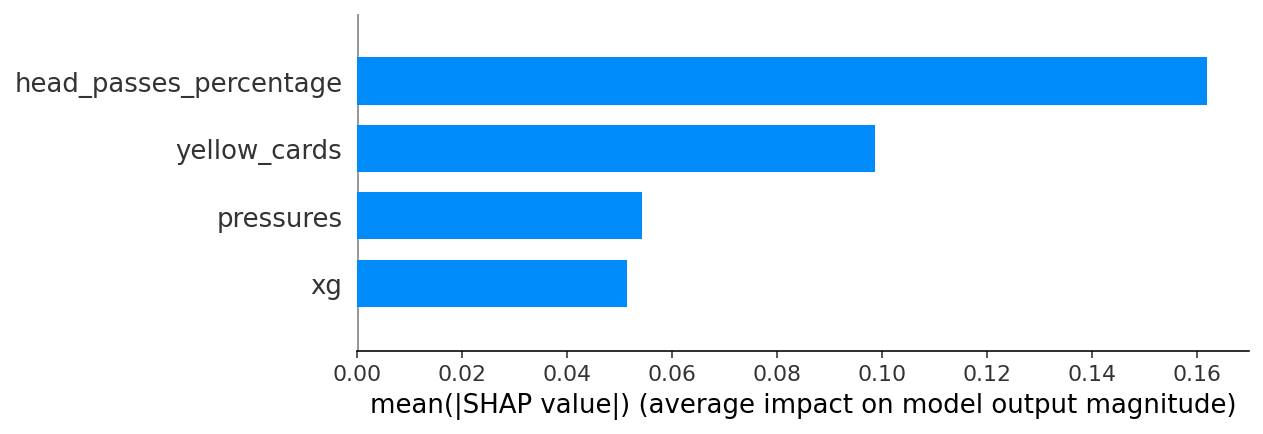

In [25]:
shap.initjs()
shap_totals = []

X_test_df = pd.DataFrame(test_features)
X_test_df.columns = dataset[list(sfs1.subsets_[4]['feature_names'])].columns


# explain all the predictions in the test set
explainer = shap.KernelExplainer(svc.predict_proba, train_features)
shap_values = explainer.shap_values(test_features)[1]

shap.summary_plot(shap_values, X_test_df, plot_type = "bar")

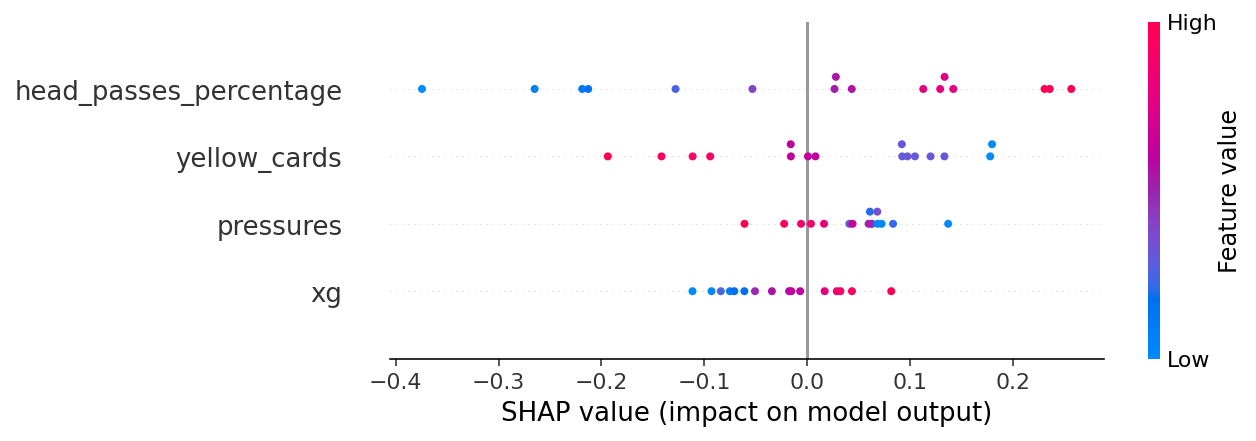

In [26]:
shap.summary_plot(shap_values, X_test_df)

### Let's analyze the impact of each player on these most important factors

In [49]:
player_style = pd.read_csv('Players.csv')
New_Players = pd.read_csv('Players_last_matches.csv').drop('Unnamed: 0',axis=1)



#head_passes_percentage
player_style = player_style.assign(head_passes=player_style['head_passes'] / player_style['passes_attempted'])
player_style = player_style.rename(columns = {'head_passes':'head_passes_percentage'})
player_style['head_passes_percentage'] = player_style['head_passes_percentage'].fillna(0)

New_Players = New_Players.assign(head_passes=New_Players['head_passes'] / New_Players['passes_attempted'])
New_Players = New_Players.rename(columns = {'head_passes':'head_passes_percentage'})
New_Players['head_passes_percentage'] = New_Players['head_passes_percentage'].fillna(0)

E_player = player_style[player_style['team_name'] == 'Everton' ].reset_index().drop('index',axis=1)
name_player =  E_player['player'].unique().astype(str)


#Correction imprecisions data-set
name_player = np.delete(name_player, [13,14,17,18,19,22,23])
name_player = np.append(name_player,'Joshua King')

correct_name_player = E_player['player'].unique().astype(str)
correct_name_player = np.delete(correct_name_player, [13,14,17,18,19,22,23])
correct_name_player[2] = 'James Rodriguez'
correct_name_player[4] = 'Abdoulaye Doucourè'
correct_name_player[6] = 'Andrè Gomes'
correct_name_player[13] = 'Gylfi Sigurusson'
correct_name_player[15] = 'Séamus Coleman'
correct_name_player = np.append(correct_name_player,'Joshua King')



# Preparing the data
scaler = StandardScaler()

# Yellow cards
frames = [E_player['yellow_cards'], New_Players['yellow_cards'] ]
yellow_cards = pd.DataFrame(scaler.fit_transform(pd.concat(frames,axis=0).reset_index().drop('index',axis=1)))


#xG
frames = [E_player['xg'], New_Players['xg'] ]
xg = pd.DataFrame(scaler.fit_transform(pd.concat(frames,axis=0).reset_index().drop('index',axis=1)))


#Pressures
frames = [E_player['pressures'], New_Players['pressures']]
pressures = pd.DataFrame(scaler.fit_transform(pd.concat(frames,axis=0).reset_index().drop('index',axis=1)))


#head_passes_percentage
frames = [E_player['head_passes_percentage'], New_Players['head_passes_percentage'] ]
head_passes_percentage = pd.DataFrame(scaler.fit_transform(pd.concat(frames,axis=0).reset_index().drop('index',axis=1)))


frames = [E_player['minutes_played'], New_Players['minutes_played'] ]
total_minutes_played = pd.DataFrame(scaler.fit_transform(pd.concat(frames,axis=0).reset_index().drop('index',axis=1)))

frames = [E_player['date'], New_Players['date'] ]
total_date = pd.concat(frames,axis=0).reset_index().drop('index',axis=1)

frames = [E_player['player'], New_Players['player'] ]
total_player = pd.concat(frames,axis=0).reset_index().drop('index',axis=1)



# SPI- index 
spi = pd.read_csv('spi_matches.csv')

spi['date'] = pd.to_datetime(spi['date'])
spi['date'] = spi['date'].dt.date
opp = []

for i in range(spi.shape[0]):
    if(spi.date[i] > datetime.date(2020, 9, 20) and spi.date[i] < datetime.date(2021,3 , 6) and
       (spi.team1[i] == 'Everton' or spi.team2[i] == 'Everton') and spi.league[i] == 'Barclays Premier League'):
            
            spi_values = []
            if(spi.iloc[i,4] == 'Everton'):
                spi_values.append(spi.iloc[i,7])
                spi_values.append(spi.iloc[i,1])
            else:
                spi_values.append(spi.iloc[i,6])
                spi_values.append(spi.iloc[i,1])
            
            opp.append(spi_values)
        
# Standardization 
save = []
for i in range(len(opp)):
    save.append(opp[i][0])

save2 = pd.DataFrame(scaler.fit_transform(pd.DataFrame(save)))
for i in range(len(opp)):
    opp[i][0] = save2.iloc[i,0]
    


# Index computation
weights = []
for j in range(total_player.shape[0]):
        for z in range(len(opp)):
            if ( datetime.datetime.strptime(total_date['date'][j], '%d/%m/%Y').date() == opp[z][1]):
                    weights.append(total_minutes_played[0][j] * opp[z][0]) 


prova = []
for i in range(name_player.shape[0]):
    tot = 0 
    sum_weights  = 0
    for j in range(total_player.shape[0]):
        if(total_player['player'][j] == name_player[i]):
            tot = ( (-yellow_cards[0][i] * 0.1 + xg[0][i]*0.05 - pressures[0][i]*0.051 + head_passes_percentage[0][i] *0.16)/0.361)*weights[i] + tot
            sum_weights = weights[i] + sum_weights
    prova.append(tot/sum_weights)

# Index
HST = []
for i in range(len(prova)):
    HST.append([name_player[i], prova[i] ])
final = pd.DataFrame(HST)
final.sort_values(by=[1],ascending=False)

,0,1
7,Tom Davies,1.208310
12,Ben Godfrey,0.795295
9,Mason Holgate,0.707081
0,Dominic Calvert-Lewin,0.519574
8,Fabian Delph,0.451824
14,Yerry Mina,0.430547
15,S�amus Coleman,0.281910
4,Abdoulaye Doucour�,0.147611
11,Michael Keane,0.055144
2,James Rodr�guez,0.011511


[[Text(0.23, 0.494053663367061, 'Niels Nkounkou')]]

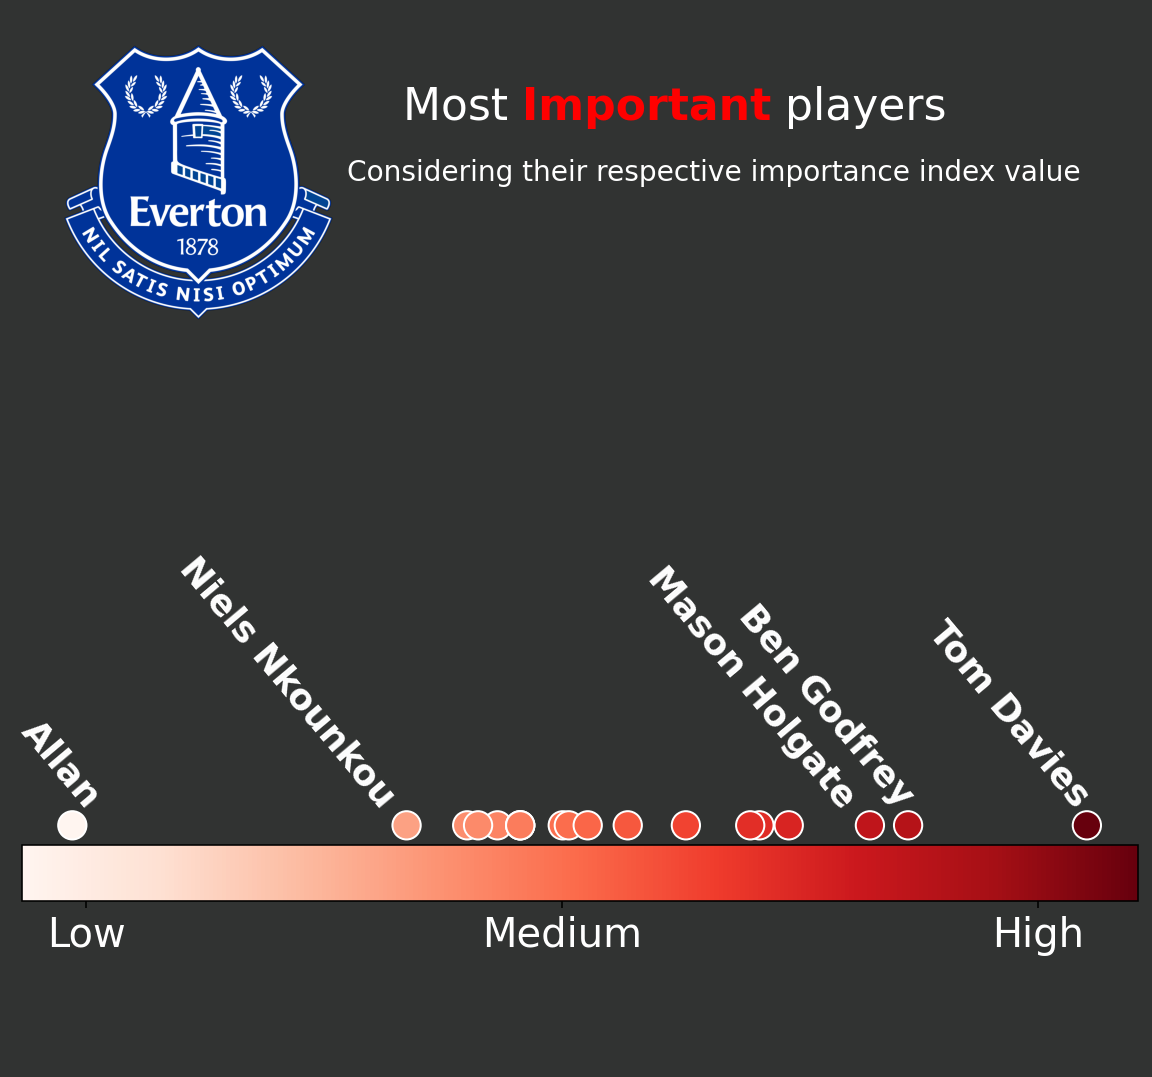

In [50]:
# Final graph

fig, ax = plt.subplots(figsize=(10,8))
fig.set_facecolor('#313332')
ax.patch.set_facecolor('#313332')
plt.ylim(-0.5, 2) 

frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
frame1.axes.spines['top'].set_visible(False)
frame1.axes.spines['right'].set_visible(False)
frame1.axes.spines['bottom'].set_visible(False)
frame1.axes.spines['left'].set_visible(False)

s = "Most <{}> players\n"
htext.fig_text(s=s.format("Important"),
               y=0.82,
               x=0.39,
               highlight_colors=["Red"], 
               highlight_weights=["bold"],
               fontsize=22,
               color="white")

c = final[1]
plt.scatter(x=final[1],
            y=[0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12],
            c=c,
            edgecolor='white',
            s=200,
            cmap = 'Reds')

ax.set_title("Considering their respective importance index value", 
             y=0.91, x=0.62,fontsize=14,c='white')

norm = plt.Normalize(final[1].min(), final[1].max())
sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
cbar = fig.colorbar(sm, ticks=[-1, 0, 1], orientation='horizontal',pad=-0.25)
cbar.ax.set_xticklabels(['Low', 'Medium', 'High'], c='white')
cbar.ax.tick_params(labelsize=20)

ax2 = fig.add_axes([0.099,0.66,0.3,0.3]) # badge
ax2.axis("off")
url = "https://logodownload.org/wp-content/uploads/2019/04/everton-logo-escudo-0.png"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
ax2.imshow(img)

s = "<{}>"
htext.fig_text(s=s.format(correct_name_player[7]),
               y=0.265,
               x=0.750,
               highlight_colors=['white'], 
               highlight_weights=["bold"],
               fontsize=18,
               color="white",
               rotation = 310)

s = "<{}>"
htext.fig_text(s=s.format(correct_name_player[12]),
               y=0.265,
               x=0.618,
               highlight_colors=['white'], 
               highlight_weights=["bold"],
               fontsize=18,
               color="white",
               rotation = 310)

s = "<{}>"
htext.fig_text(s=s.format(correct_name_player[9]),
               y=0.265,
               x=0.555,
               highlight_colors=['white'], 
               highlight_weights=["bold"],
               fontsize=18,
               color="white",
               rotation = 310)

s = "<{}>"
htext.fig_text(s=s.format(correct_name_player[3]),
               y=0.265,
               x=0.120,
               highlight_colors=['white'], 
               highlight_weights=["bold"],
               fontsize=18,
               color="white",
               rotation = 310)

s = "<{}>"
htext.fig_text(s=s.format(correct_name_player[17]),
               y=0.265,
               x=0.230,
               highlight_colors=['white'], 
               highlight_weights=["bold"],
               fontsize=18,
               color="white",
               rotation = 310)